In [1]:
%matplotlib inline
from common import *

In [2]:
import unittest.mock as mock
import lzma, pickle

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
northside, grid = load(datadir)

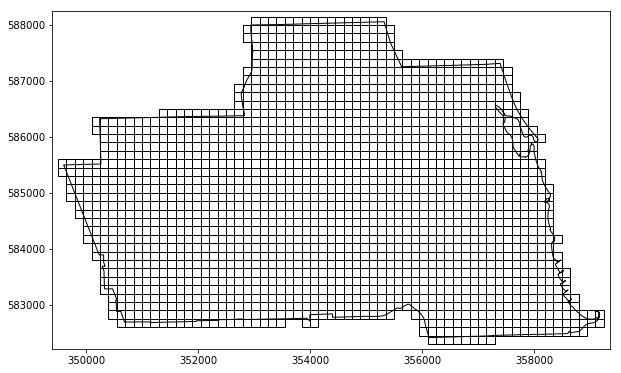

In [4]:
p = open_cp.plot.patches_from_grid(grid)

fig, ax = plt.subplots(figsize=(10,10))
ax.add_collection(matplotlib.collections.PatchCollection(p, facecolor="none", edgecolor="black"))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))

xmin, ymin, xmax, ymax = northside.bounds
d = 200
ax.set(xlim=[xmin-d,xmax+d], ylim=[ymin-d, ymax+d])
ax.set_aspect(1)
None

In [5]:
fig.savefig("grid_over_outline.pdf", dpi=200)

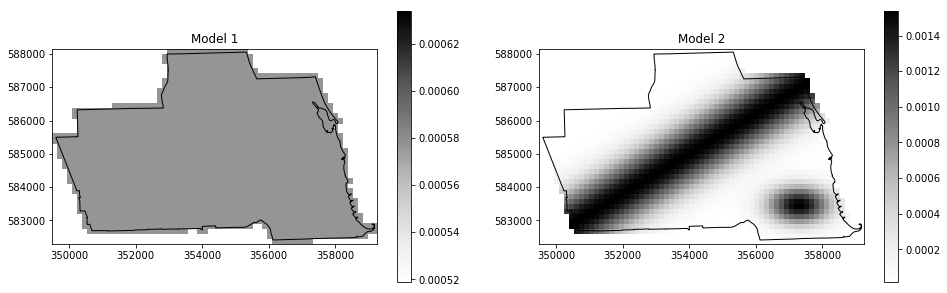

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

for ax, Model in zip(axes, [Model1, Model2]):
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    m = Model(grid)
    pred = m.to_prediction()
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
    plt.colorbar(m, ax=ax)

axes[0].set_title("Model 1")
axes[1].set_title("Model 2")

In [7]:
fig.savefig("model_intensity.pdf")

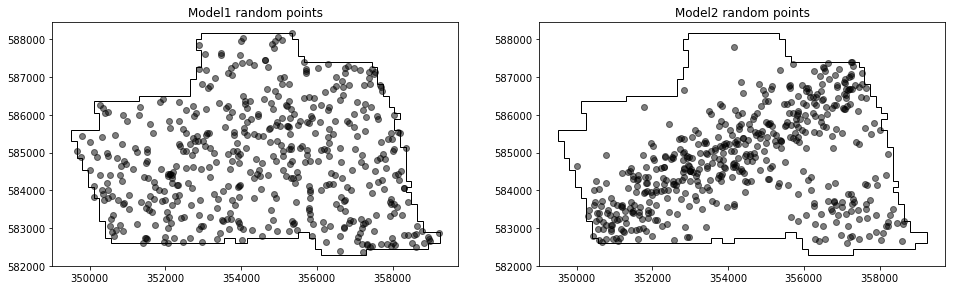

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
for ax, model in zip(axes, [Model1, Model2]):
    grid_outline = open_cp.plot.outline_of_grid(grid)
    ax.add_patch(descartes.PolygonPatch(grid_outline, fc="none"))
    ax.set_aspect(1)
    m = model(grid)
    pt = sample(m, 500)
    ax.scatter(*pt.T, alpha=0.5, color="black")
    ax.set_title("{} random points".format(m))
#fig.tight_layout()

In [9]:
fig.savefig("model_example_points.pdf")

In [10]:
#all_data = make_data_preds(grid)

#import pickle, lzma

#with lzma.open("synth_temp.pic.xz", "wb") as f:
#    pickle.dump(all_data, f)

#os.stat("synth_temp.pic.xz").st_size / 1024 / 1024

In [12]:
with lzma.open("synth_temp.pic.xz", "rb") as f:
    all_data = pickle.load(f)

# Hit rate

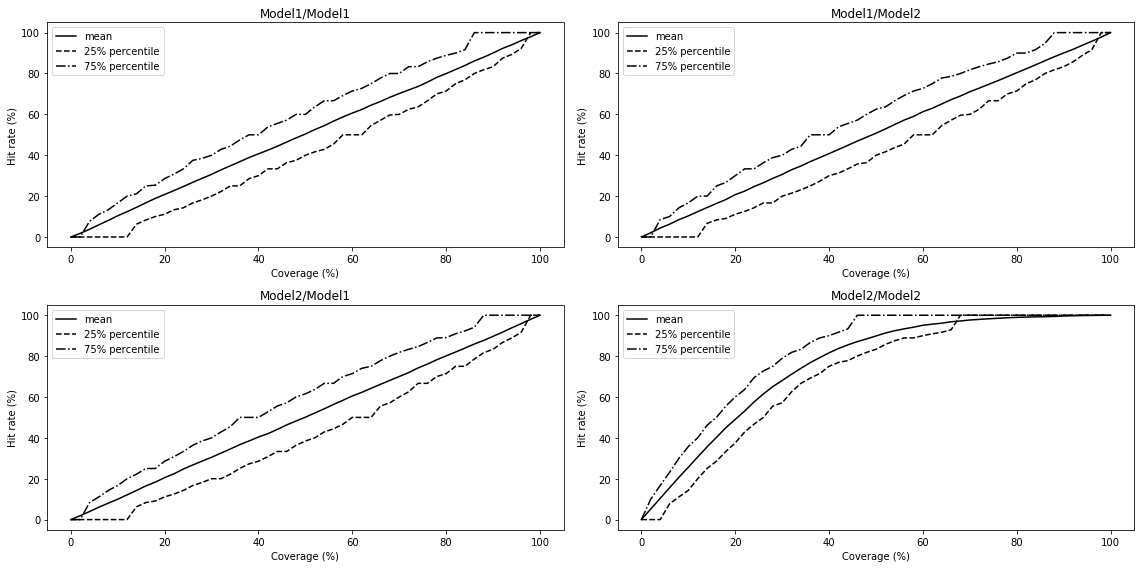

In [12]:
data = process(all_data, open_cp.evaluation.inverse_hit_rates)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
plot_hit_rate(data, fig)
fig.tight_layout()

In [13]:
fig.savefig("hitrate1.pdf")

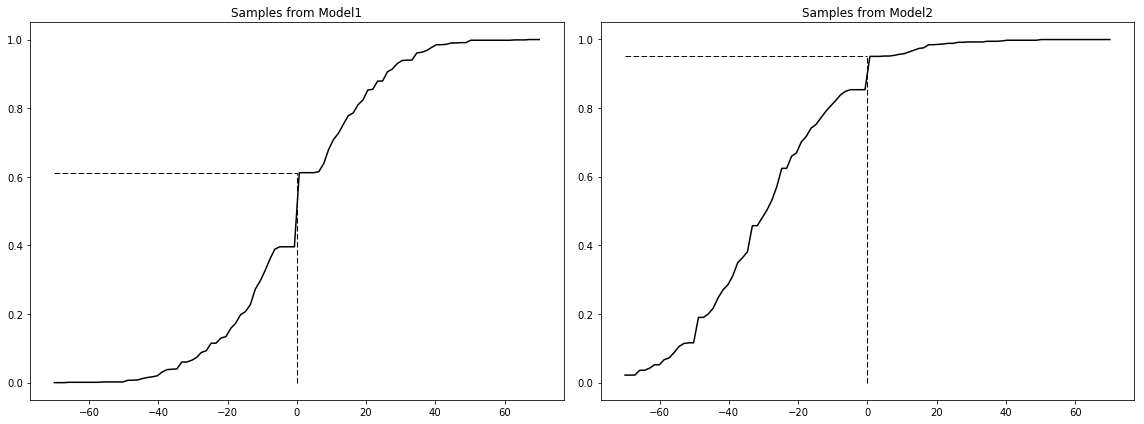

In [14]:
new_data = { k : hitrate_inverse_to_hitrate(v, {20})[20] for k,v in data.items()}
fig, axes = plot_paired_data(new_data, comparison_uni_paired(-70, 70))
fig.tight_layout()

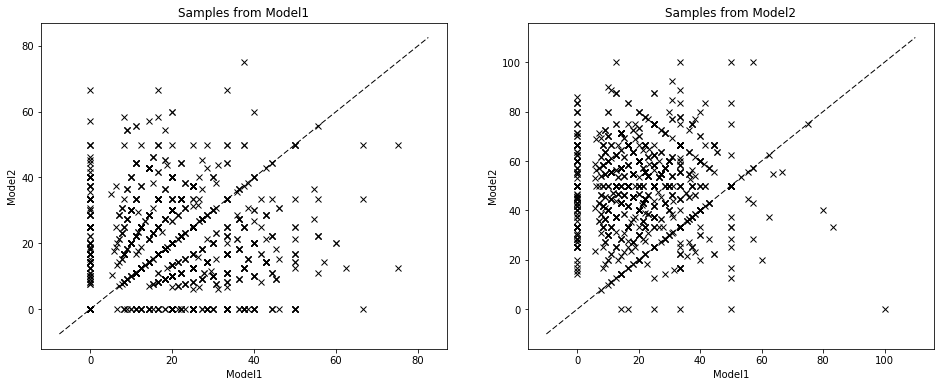

In [15]:
fig, axes = plot_paired_data(new_data, scatter_uni_paired_plot_func)
label_scatter_uni_paired(fig, axes)
#fig.tight_layout()

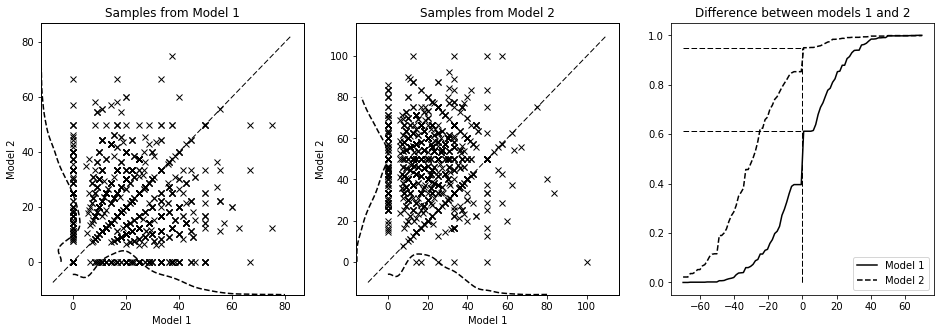

In [16]:
def three_up_hit_rate_plot(cov, xlimit=80):
    new_data = { k : hitrate_inverse_to_hitrate(v, {cov})[cov] for k,v in data.items()}
    fig = three_up_plot(new_data, -70, 70)
    for one_model, ax in zip(data_by_source_model(new_data), fig.axes):
        d = paired_data(one_model)
        ax1, ax2 = add_kernels(ax, d, (0, xlimit), 0.2, color="black", linestyle="--")
    return fig
fig = three_up_hit_rate_plot(20)

In [17]:
fig.savefig("hitrate2.pdf")

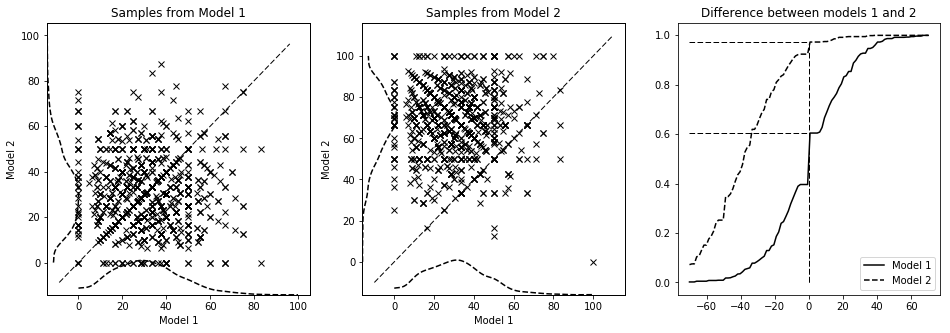

In [18]:
_ = three_up_hit_rate_plot(30, 100)

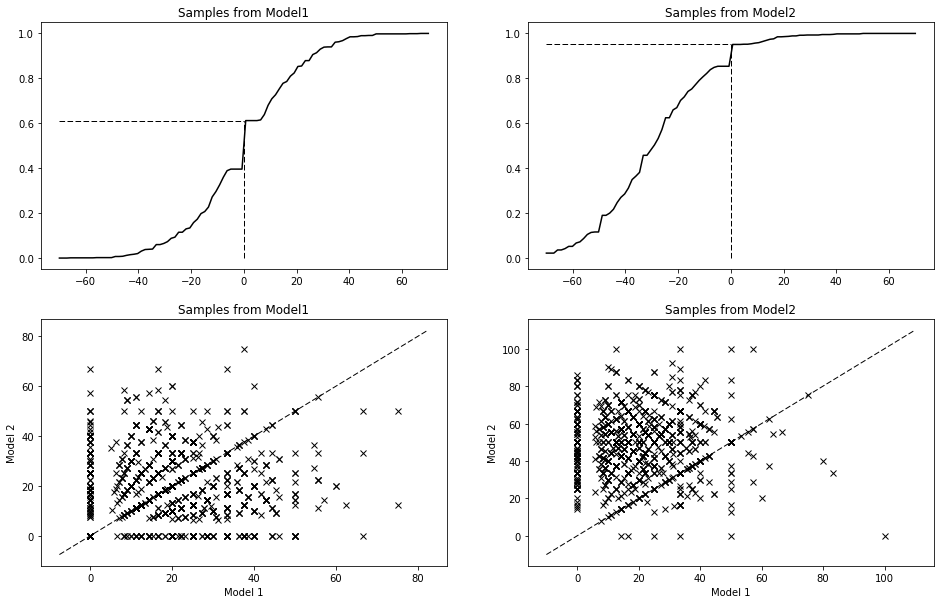

In [19]:
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
joint_paired_data(new_data, comparison_uni_paired(-70, 70), scatter_uni_paired_plot_func, fig)
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

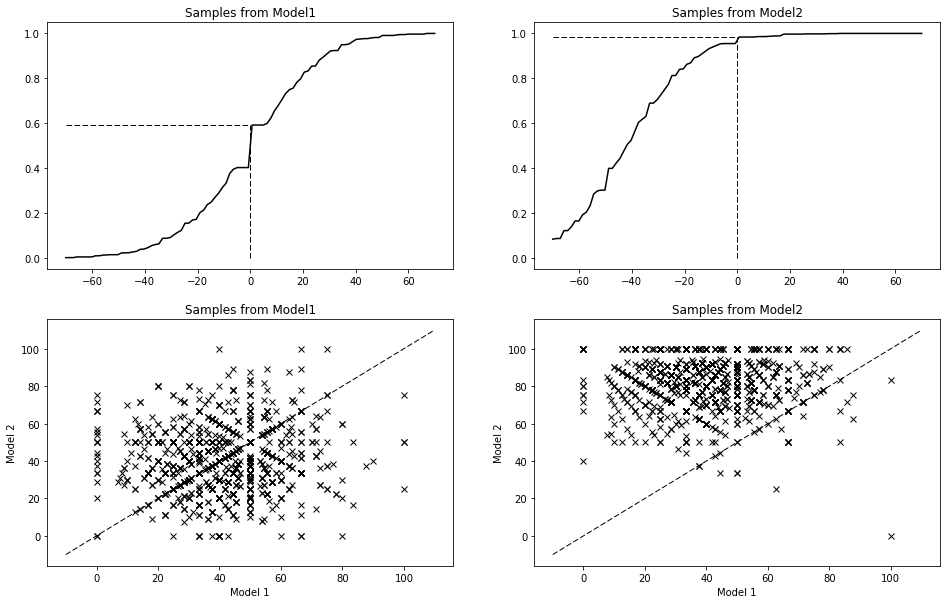

In [20]:
new_data = { k : hitrate_inverse_to_hitrate(v, {40})[40] for k,v in data.items()}
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
joint_paired_data(new_data, comparison_uni_paired(-70, 70), scatter_uni_paired_plot_func, fig)
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

# Ranking

In [21]:
def func(pred, tps):
    rankings = open_cp.evaluation.ranking_score(pred, tps)
    return np.mean(rankings)

rankings = process(all_data, func)

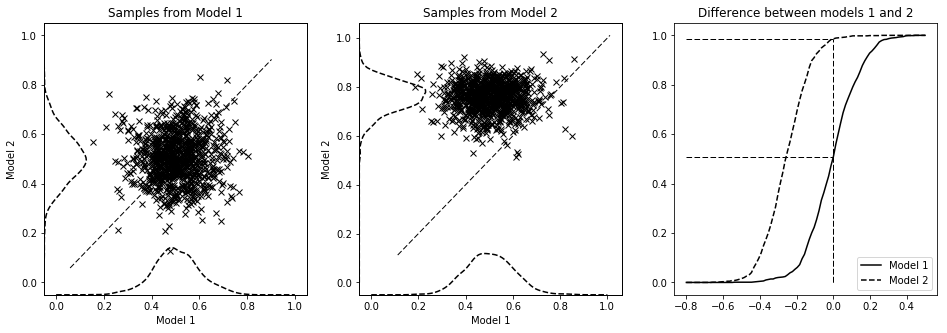

In [25]:
fig = three_up_plot(rankings, -0.8, 0.5)
for one_model, ax in zip(data_by_source_model(rankings), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (0, 1), 25, color="black", linestyle="--")

In [26]:
fig.savefig("ranking1.pdf")

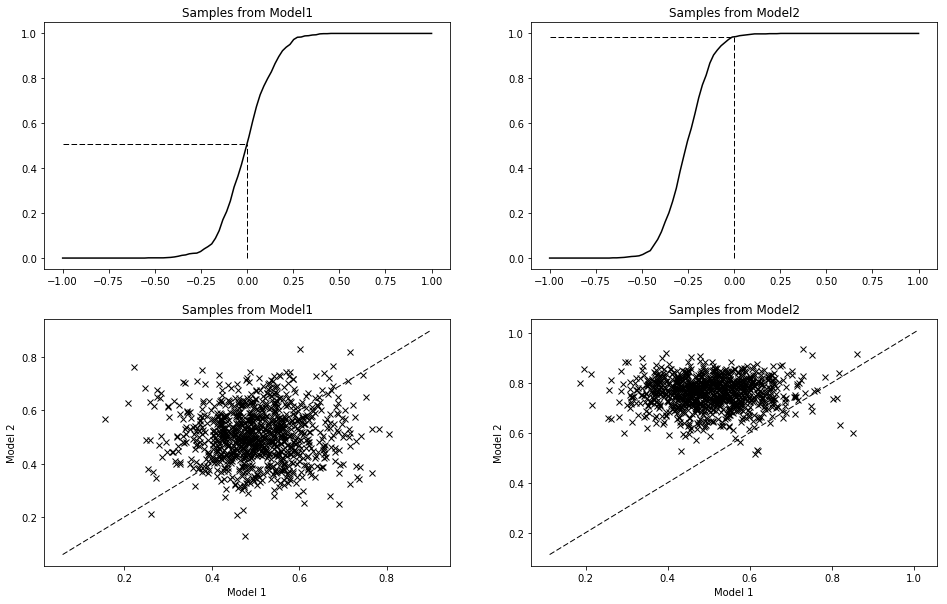

In [27]:
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
joint_paired_data(rankings, comparison_uni_paired(-1, 1), scatter_uni_paired_plot_func, fig)
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

In [35]:
deltas = process(all_data, open_cp.evaluation.ranking_score)

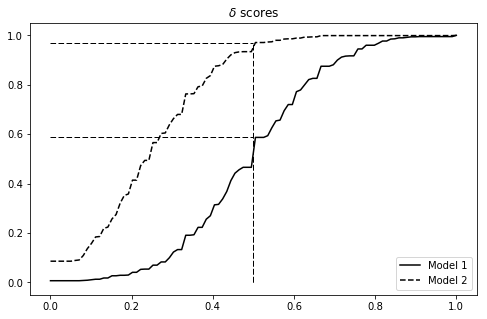

In [43]:
fig, ax = plt.subplots(figsize=(8,5))

for source, lab, ls in zip(data_by_source_model(deltas), ["Model 1", "Model 2"], ["-", "--"]):
    delta_score = [np.sum(row.one > row.two) / len(row.one)
        for row in paired_data(source)]
    cumulative_df_plot_func(ax, np.asarray(delta_score), 0, 1, midpoint=0.5, linestyle=ls, label=lab)
ax.set_title("$\delta$ scores")
ax.legend(loc = "lower right")
None

In [44]:
fig.savefig("ranking2.pdf")

# Likelihood

In [46]:
likelihoods = process(all_data, open_cp.evaluation.likelihood)

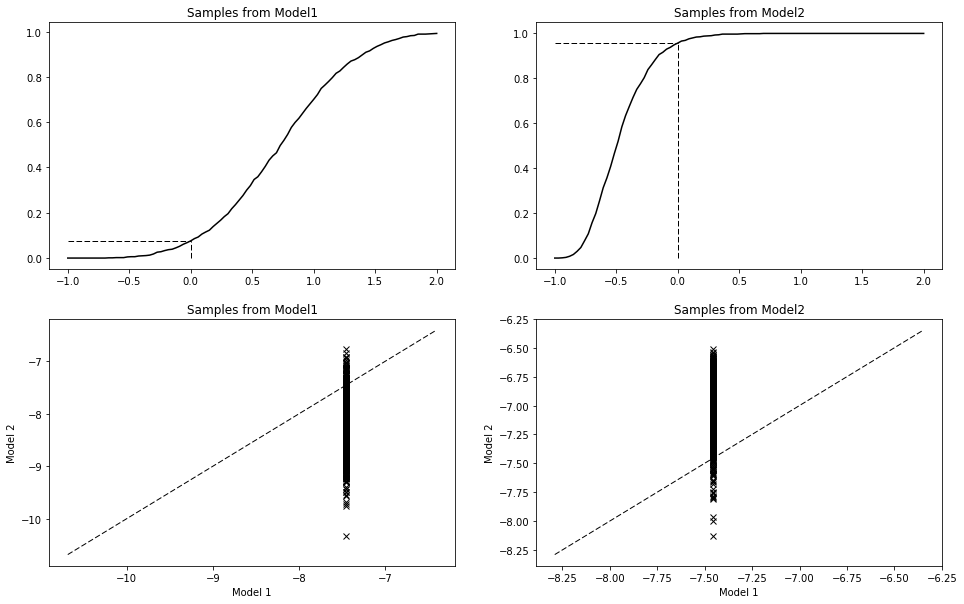

In [49]:
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
fig = joint_paired_data(likelihoods, comparison_uni_paired(-1, 2), scatter_uni_paired_plot_func, fig)
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

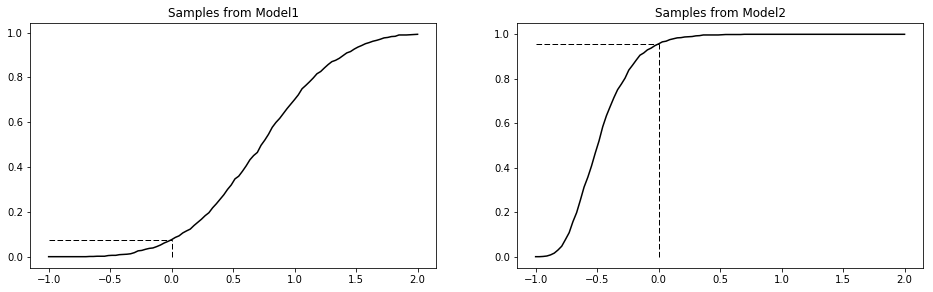

In [51]:
fig, _ = plt.subplots(ncols=2, figsize=(16,4.5))
_ = plot_paired_data(likelihoods, comparison_uni_paired(-1, 2), fig)

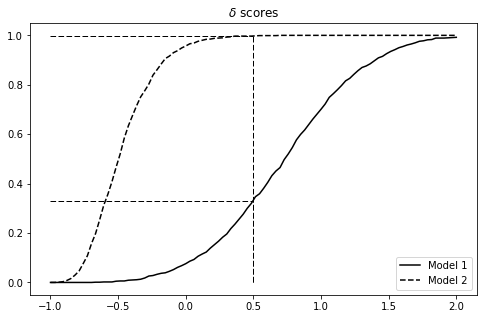

In [59]:
fig, ax = plt.subplots(figsize=(8,5))

for source, lab, ls in zip(data_by_source_model(likelihoods), ["Model 1", "Model 2"], ["-", "--"]):
    d = [row.one - row.two for row in paired_data(source)]
    cumulative_df_plot_func(ax, d, -1, 2, midpoint=0.5, linestyle=ls, label=lab)
ax.set_title("$\delta$ scores")
ax.legend(loc = "lower right")
None

In [60]:
fig.savefig("likelihood.pdf")

# KDE

Smaller score is better match, as we use mean squared error.

In [97]:
# Uses plug-in method, which takes account of covariance
kde = process(constrain_to_number_events(all_data, 3), lambda a,b : open_cp.evaluation.score_kde(a,b,grid))

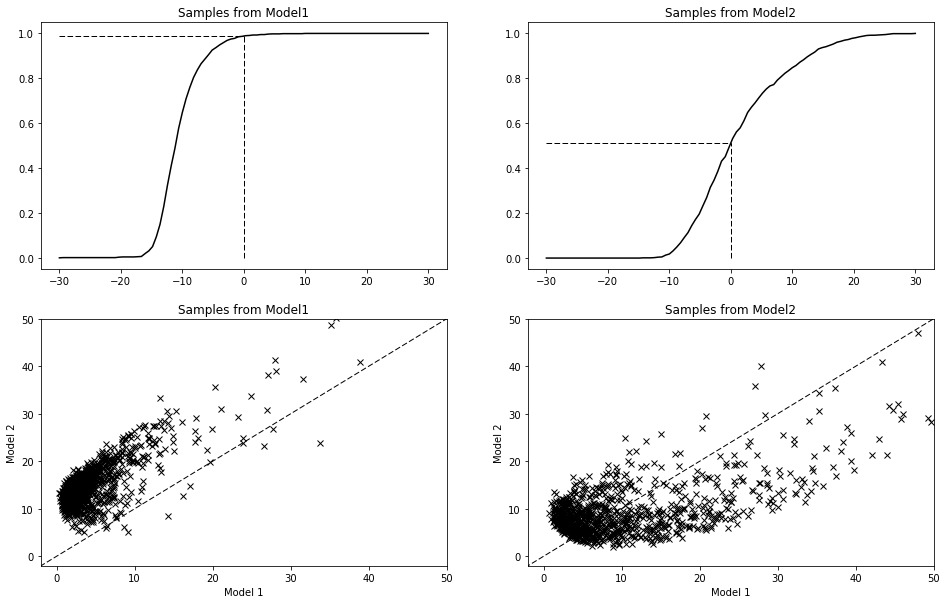

In [98]:
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
fig = joint_paired_data(kde, comparison_uni_paired(-30, 30), scatter_uni_paired_plot_func, fig)
for i in [2,3]:
    fig.axes[i].set(xlim=[-2,50], ylim=[-2,50])
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

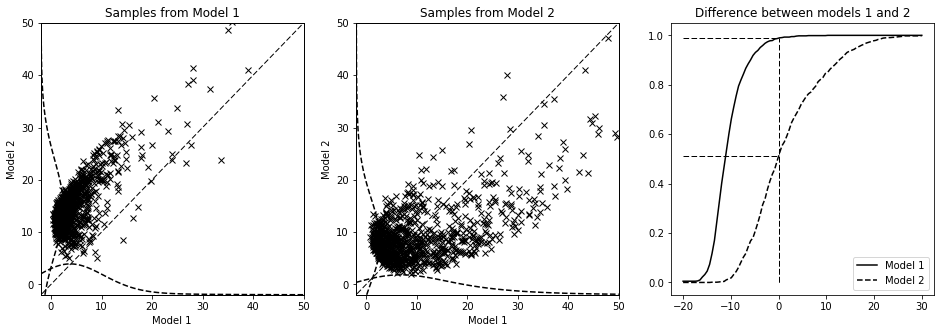

In [181]:
fig = three_up_plot(kde, -20, 30)
for one_model, ax in zip(data_by_source_model(kde), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (-2, 50), 0.5, color="black", linestyle="--")
for i in [0, 1]:
    fig.axes[i].set(xlim=[-2,50], ylim=[-2,50])

In [182]:
fig.savefig("kde.pdf")

In [67]:
by_bandwidth = {}
for bw in [50, 100, 300, 500, 1000]:
    by_bandwidth[bw] = process(constrain_to_number_events(all_data, 3),
                               lambda a,b : open_cp.evaluation.score_kde_fixed_bandwidth(a,b,grid,bw))

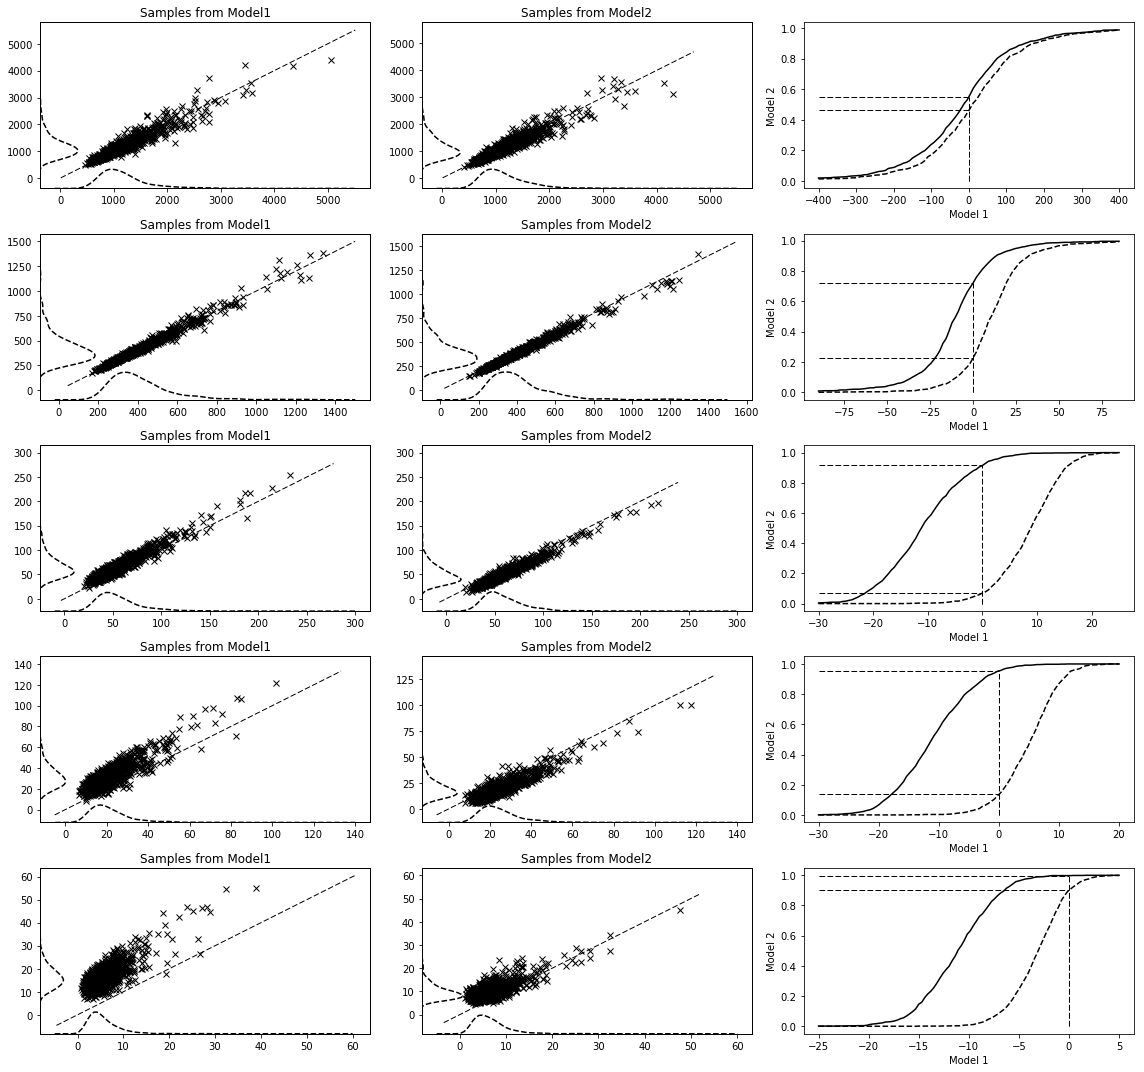

In [190]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(16,15))

bounds = {50 : (-400, 400),
         100 : (-90, 85),
         300 : (-30, 25),
         500 : (-30, 20),
         1000 : (-25, 5)
         }
axis_sizes = {50 : (-100,5500),
             100 : (-20, 1500),
             300 : (-10, 300),
             500 : (-5, 140),
             1000 : (-5, 60)}
ker_scale = {50:1e-2, 100:2e-2, 300:0.2, 500:0.5, 1000:1.2}

for row, (bw, data) in zip(axes, by_bandwidth.items()):
    import unittest.mock as mock
    f = mock.Mock()
    f.axes = row[:2]
    plot_paired_data(data, scatter_uni_paired_plot_func, f)
    for one_model, ax in zip(data_by_source_model(data), row):
        d = paired_data(one_model)
        ax1, ax2 = add_kernels(ax, d, axis_sizes[bw], ker_scale[bw], color="black", linestyle="--")
    func = comparison_uni_paired(*bounds[bw])
    for one_model, lab, ls in zip(data_by_source_model(data), ["Model 1", "Model 2"],
                                 ["-", "--"]):
        func(row[2], paired_data(one_model), label=lab, linestyle=ls)
    row[2].set(xlabel="Model 1", ylabel="Model 2")
fig.tight_layout()

In [191]:
fig.savefig("kde1.pdf")

Some code for an abandoned idea: use kernel estimation and a contour plot to summarise the scatter plot.  Hampered by the differing scales.

In [163]:
def make_kernel(source_data):
    pts = np.asarray([[row.one, row.two] for row in paired_data(source_data)])
    ker = scipy.stats.kde.gaussian_kde(pts.T)

    x = np.linspace(0, 60, 200)
    y = np.linspace(0, 60, 200)
    xd = (x[1] - x[0]) / 2
    yd = (y[1] - y[0]) / 2
    meshx, meshy = np.meshgrid(x, y)
    z = ker([meshx.flatten() + xd, meshy.flatten() + yd]).reshape(meshx.shape)

    return pts, ker, x, y, z

def in_region_count(pts, x, y, z, cutoff):
    mask = z >= cutoff
    meshx, meshy = np.meshgrid(x, y)
    xd = (x[1] - x[0]) / 2
    yd = (y[1] - y[0]) / 2
    count = 0
    for x, y in zip(meshx[mask], meshy[mask]):
        pts_mask = (pts[:,0] >= x - xd) & (pts[:,0] < x + xd)
        pts_mask &= (pts[:,1] >= y - yd) & (pts[:,1] < y + yd)
        count += np.sum(pts_mask)
    return count / pts.shape[0]

def find_countour_level(prob, in_region_count):
    lower = 0
    upper = 1
    while in_region_count(upper) > prob:
        upper += upper
    assert in_region_count(lower) > prob
    assert in_region_count(upper) < prob

    while upper - lower > 1e-8:
        mid = (lower + upper) / 2
        frac = in_region_count(mid)
        if frac > prob:
            lower = mid
        else:
            upper = mid
    return lower

pts, ker, x, y, z = make_kernel( next(iter(data_by_source_model(by_bandwidth[1000]))) )
level = find_countour_level(0.9, lambda co : in_region_count(pts, x, y, z, co))

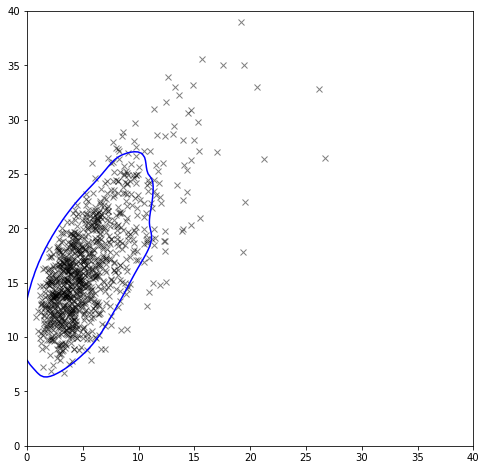

In [165]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(*pts.T, color="black", linewidth=1, marker="x", alpha=0.5)
ax.set(xlim=[0,40], ylim=[0,40])

ax.contour(x,y,z, colors="blue", levels=[level])

# Scoring rules

For the score, smaller is better.  For the skill, closer to 1 is better.

In [69]:
brier = process(all_data, open_cp.evaluation.brier_score)

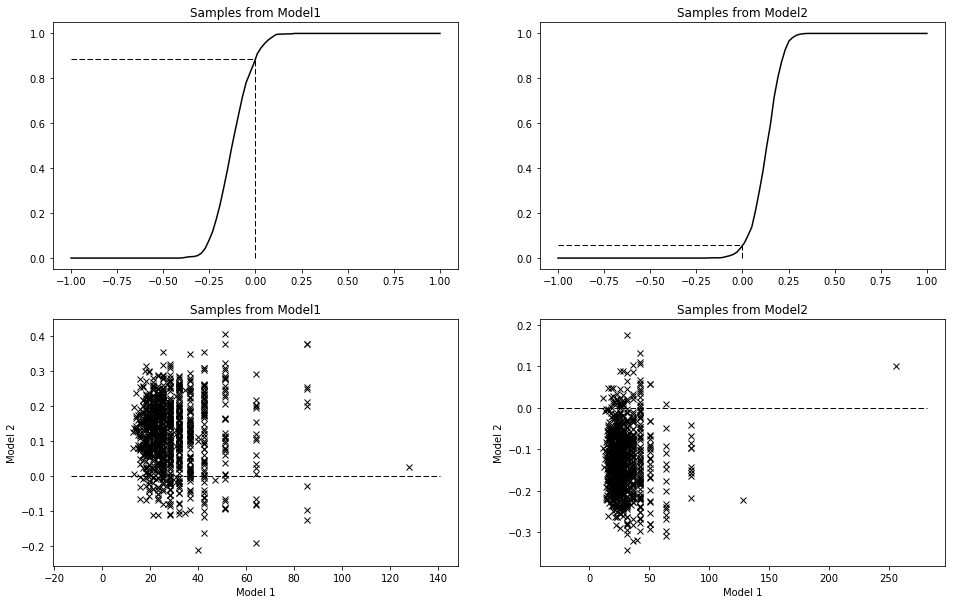

In [70]:
data = { k : v[0] * 1e10 for k, v in brier.items() }
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
fig = joint_paired_data(data, comparison_uni_paired(-1, 1), scatter_uni_paired_plot_func_diffs, fig)
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

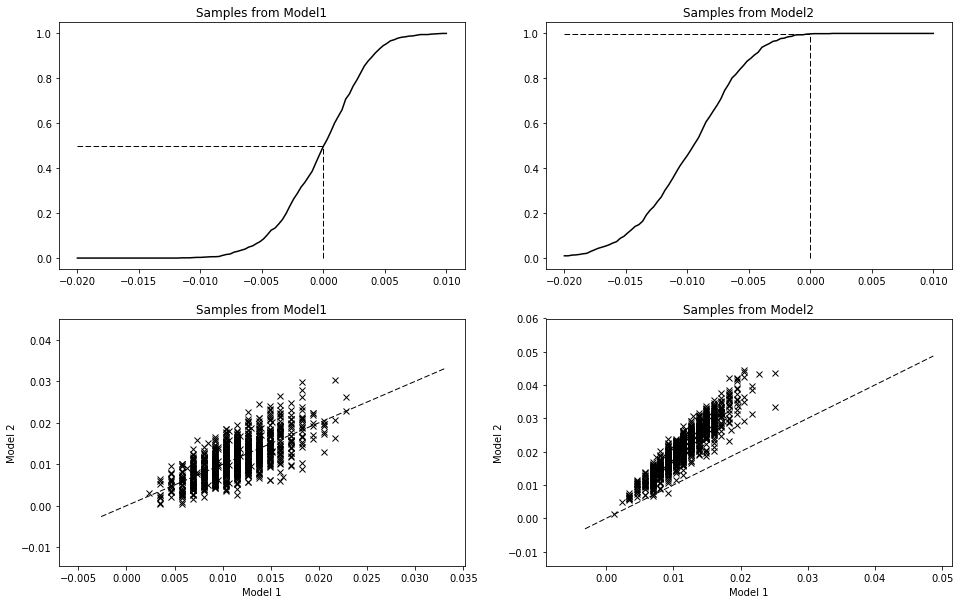

In [71]:
data = { k : v[1] for k, v in brier.items() }
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
fig = joint_paired_data(data, comparison_uni_paired(-.02, .01), scatter_uni_paired_plot_func, fig)
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

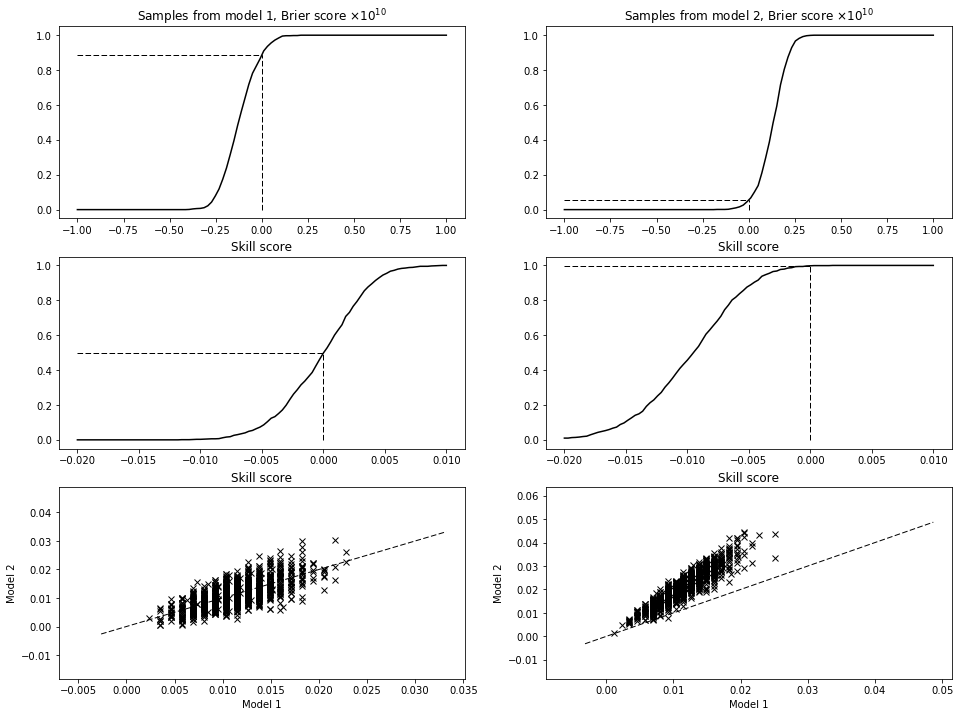

In [72]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16,12))

data = { k : v[0] * 1e10 for k, v in brier.items() }
import unittest.mock as mock
f = mock.Mock()
f.axes = axes[0]
plot_paired_data(data, comparison_uni_paired(-1, 1), f)
axes[0][0].set_title("Samples from model 1, Brier score $\\times 10^{10}$")
axes[0][1].set_title("Samples from model 2, Brier score $\\times 10^{10}$")

data = { k : v[1] for k, v in brier.items() }
f.axes = axes[1]
plot_paired_data(data, comparison_uni_paired(-.02, .01), f)
for ax in axes[1]:
    ax.set_title("Skill score")
f.axes = axes[2]
plot_paired_data(data, scatter_uni_paired_plot_func, f)
for ax in axes[2]:
    ax.set_title("Skill score")
    ax.set(xlabel="Model 1", ylabel="Model 2")

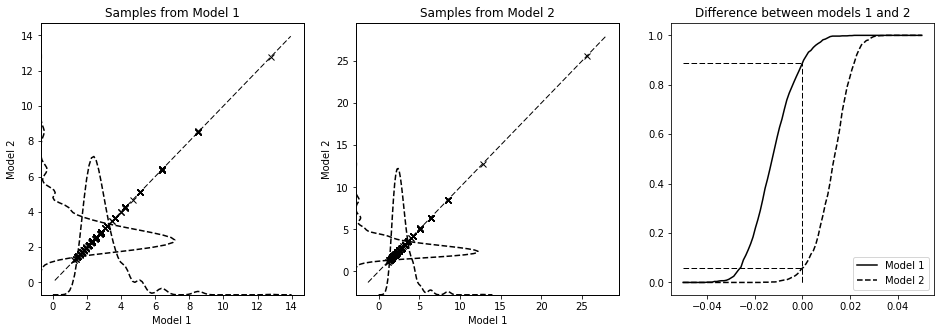

In [223]:
data = {k:v[0] * 1e9 for k,v in brier.items()}

fig = three_up_plot(data, -.05, .05)
for one_model, ax in zip(data_by_source_model(data), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (0, 14), 1, color="black", linestyle="--")

In [224]:
fig.savefig("brier.pdf")

[(-0.005, 0.055), (-0.005, 0.04)]

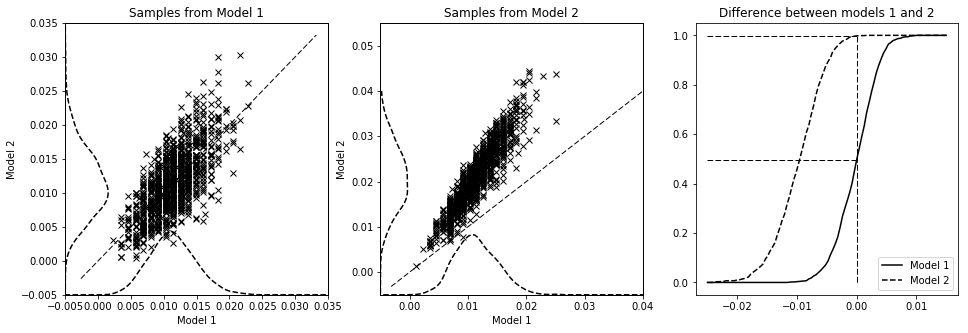

In [225]:
data = {k:v[1] for k,v in brier.items()}

fig = three_up_plot(data, -0.025, 0.015)
for one_model, ax in zip(data_by_source_model(data), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (-0.01, 0.04), 500, color="black", linestyle="--")
fig.axes[0].set(xlim=[-0.005, 0.035], ylim=[-0.005, 0.035])
fig.axes[1].set(xlim=[-0.005, 0.04], ylim=[-0.005, 0.055])

In [226]:
fig.savefig("brier1.pdf")

In [74]:
po_brier = process(all_data, open_cp.evaluation.poisson_crps_score)

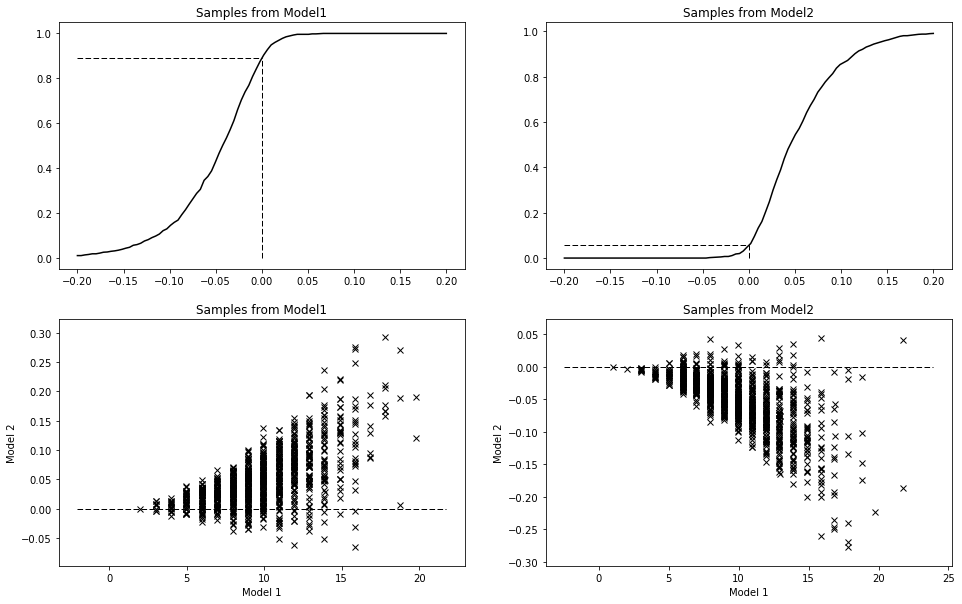

In [75]:
data = po_brier
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
fig = joint_paired_data(data, comparison_uni_paired(-.2, .2), scatter_uni_paired_plot_func_diffs, fig)
for ax in fig.axes[2:]:
    ax.set(xlabel="Model 1", ylabel="Model 2")

(<matplotlib.figure.Figure at 0x204e0600438>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000204DFEE6FD0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000204E0CD3438>], dtype=object))

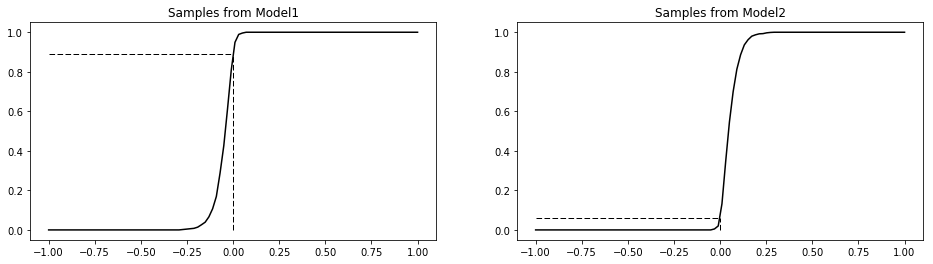

In [228]:
fig, axes = plt.subplots(ncols=2, figsize=(16,4))
data = po_brier
plot_paired_data(data, comparison_uni_paired(-1, 1), fig)

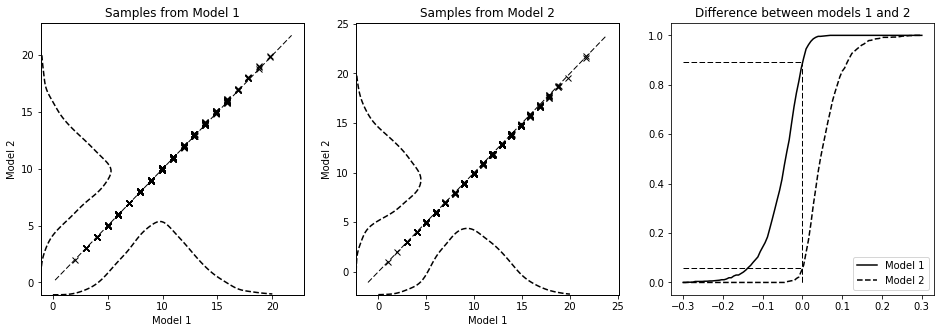

In [232]:
fig = three_up_plot(po_brier, -0.3, 0.3)
for one_model, ax in zip(data_by_source_model(po_brier), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (0, 20), 0.5, color="black", linestyle="--")

In [233]:
fig.savefig("po_brier.pdf")

### Multiscale Brier

I am really unsure how to visualise this.

In [491]:
grid

MaskedGrid(offset=(349500,582300), size=150x150, mask region=65x39)

In [492]:
sizes = [1,2,3,6,10, 15,20,25,32,39]

In [493]:
brier_ms = {s : process(all_data, lambda p, t : open_cp.evaluation.multiscale_brier_score(p, t, size=s))
            for s in sizes}

Firstly, plot a load of scatter plots at different aggregation levels.

- Bottom axis is always the score for the model 1 prediction.
- Lower score is better; higher skill is better.

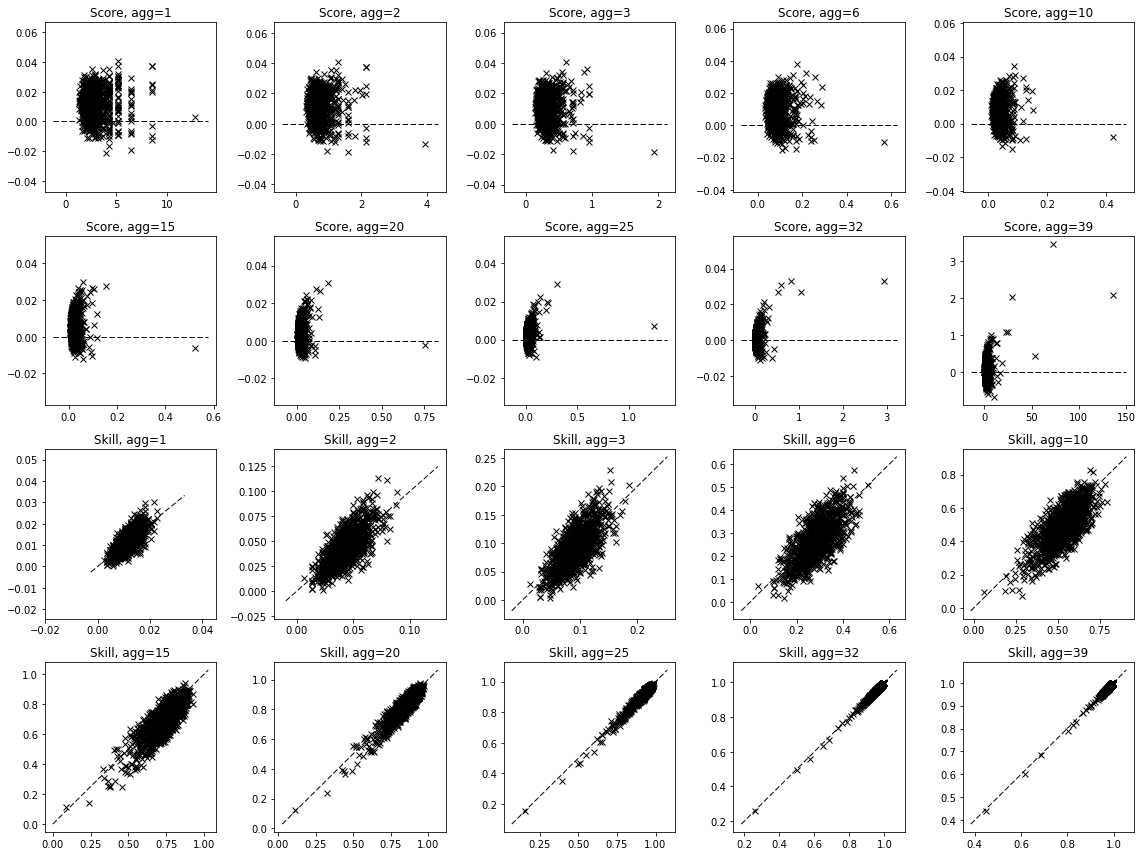

In [495]:
# Model 1 data
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16,12))

for ax, size in zip(axes.flatten(), sizes):
    model = list(data_by_source_model(brier_ms[size]))[0]
    data = paired_data({k:v[0]*1e9 for k,v in model.items()})
    scatter_uni_paired_plot_func_diffs(ax, data)
    ax.set_title("Score, agg={}".format(size))
for ax, size in zip(axes.flatten()[10:], [1,2,3,6,10, 15,20,25,32,39]):
    model = list(data_by_source_model(brier_ms[size]))[0]
    data = paired_data({k:v[1] for k,v in model.items()})
    scatter_uni_paired_plot_func(ax, data)
    ax.set_title("Skill, agg={}".format(size))
fig.tight_layout()

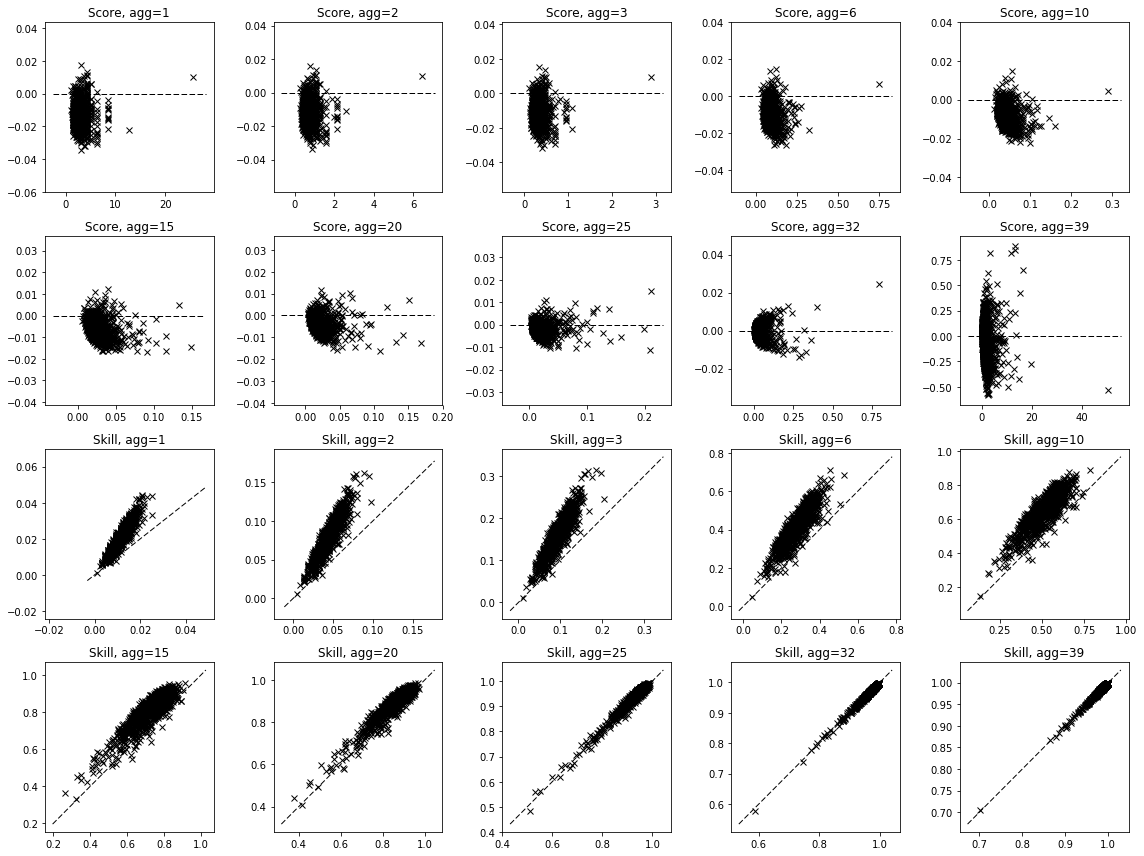

In [496]:
# Model 2 data
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16,12))

for ax, size in zip(axes.flatten(), sizes):
    model = list(data_by_source_model(brier_ms[size]))[1]
    data = paired_data({k:v[0]*1e9 for k,v in model.items()})
    scatter_uni_paired_plot_func_diffs(ax, data)
    ax.set_title("Score, agg={}".format(size))
for ax, size in zip(axes.flatten()[10:], [1,2,3,6,10, 15,20,25,32,39]):
    model = list(data_by_source_model(brier_ms[size]))[1]
    data = paired_data({k:v[1] for k,v in model.items()})
    scatter_uni_paired_plot_func(ax, data)
    ax.set_title("Skill, agg={}".format(size))
fig.tight_layout()

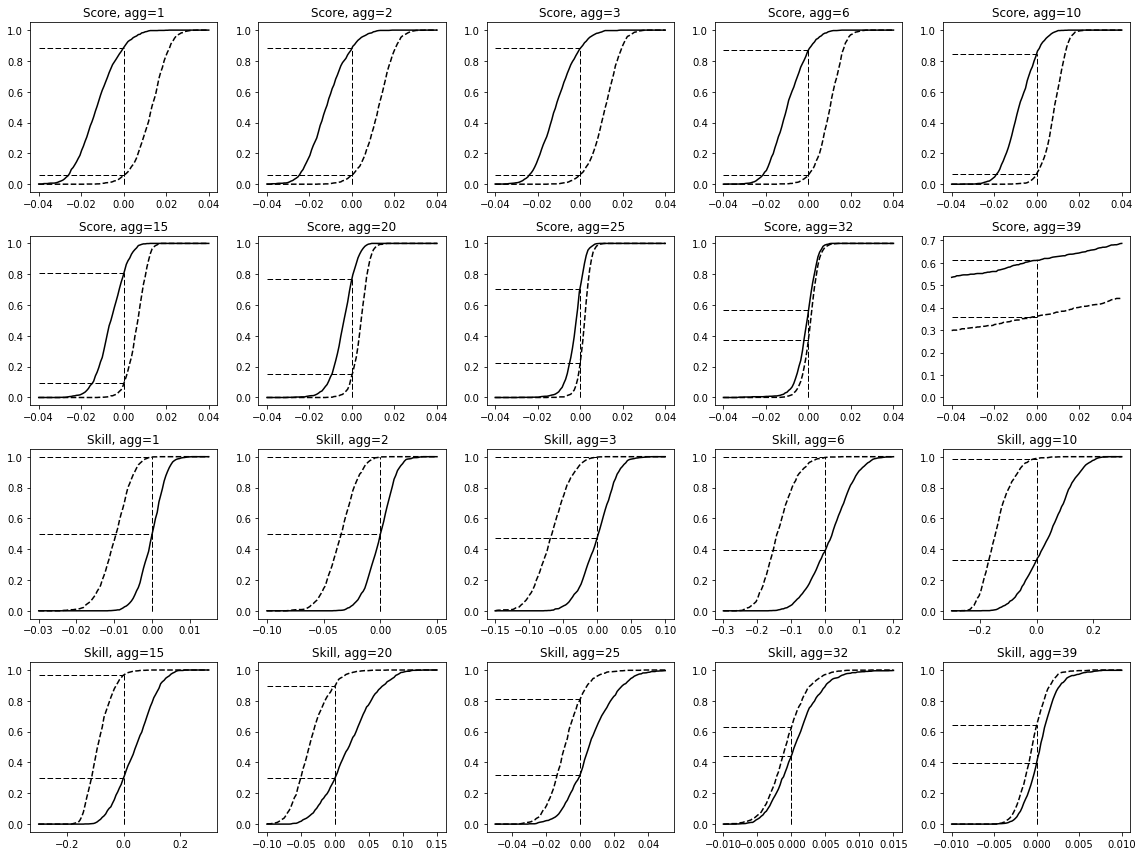

In [497]:
# Model 2 data
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16,12))

func = comparison_uni_paired(-0.04, 0.04)
for ax, size in zip(axes.flatten(), [1,2,3,6,10, 15,20,25,32,39]):
    data = brier_ms[size]
    data = {k:v[0]*1e9 for k,v in data.items()}
    for one_model, lab, ls in zip(data_by_source_model(data), ["Model 1", "Model 2"],
                                 ["-", "--"]):
        func(ax, paired_data(one_model), label=lab, linestyle=ls)
    ax.set_title("Score, agg={}".format(size))
bounds = [(-0.03, 0.015), (-0.1, 0.05), (-0.15, 0.1), (-0.3, 0.2), (-0.3, 0.3),
         (-0.3, 0.3), (-0.1, 0.15), (-0.05, 0.05), (-0.01, 0.015), (-0.01, 0.01)]
for ax, size, b in zip(axes.flatten()[10:], [1,2,3,6,10, 15,20,25,32,39], bounds):
    data = brier_ms[size]
    data = {k:v[1] for k,v in data.items()}
    func = comparison_uni_paired(*b)
    for one_model, lab, ls in zip(data_by_source_model(data), ["Model 1", "Model 2"],
                                 ["-", "--"]):
        func(ax, paired_data(one_model), label=lab, linestyle=ls)
    ax.set_title("Skill, agg={}".format(size))
fig.tight_layout()

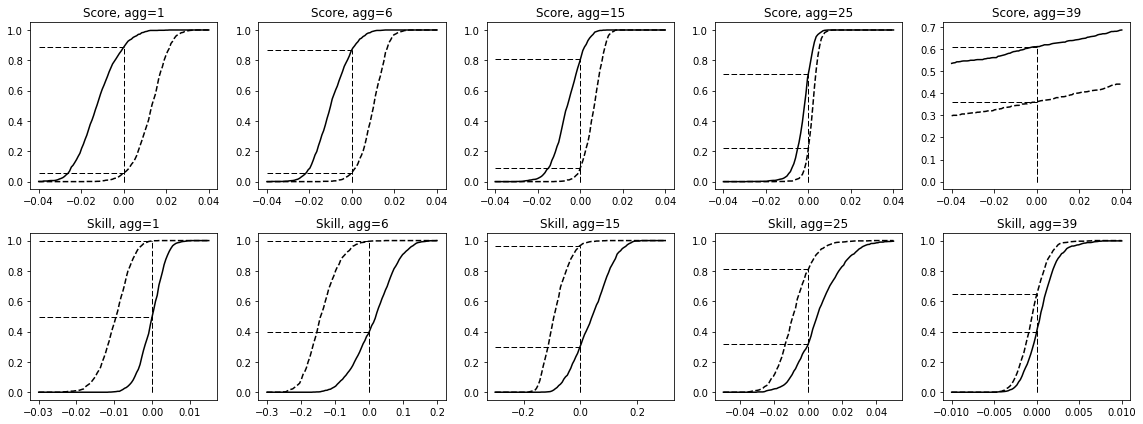

In [499]:
# Model 2 data
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))

func = comparison_uni_paired(-0.04, 0.04)
for ax, size in zip(axes[0], [1,6,15,25,39]):
    data = brier_ms[size]
    data = {k:v[0]*1e9 for k,v in data.items()}
    for one_model, lab, ls in zip(data_by_source_model(data), ["Model 1", "Model 2"],
                                 ["-", "--"]):
        func(ax, paired_data(one_model), label=lab, linestyle=ls)
    ax.set_title("Score, agg={}".format(size))
bounds = [(-0.03, 0.015), (-0.3, 0.2), (-0.3, 0.3), (-0.05, 0.05), (-0.01, 0.01)]
for ax, size, b in zip(axes[1], [1,6,15,25,39], bounds):
    data = brier_ms[size]
    data = {k:v[1] for k,v in data.items()}
    func = comparison_uni_paired(*b)
    for one_model, lab, ls in zip(data_by_source_model(data), ["Model 1", "Model 2"],
                                 ["-", "--"]):
        func(ax, paired_data(one_model), label=lab, linestyle=ls)
    ax.set_title("Skill, agg={}".format(size))
fig.tight_layout()

In [500]:
fig.savefig("brier_agged_synth.pdf")

Log-scale plots of estimated densities

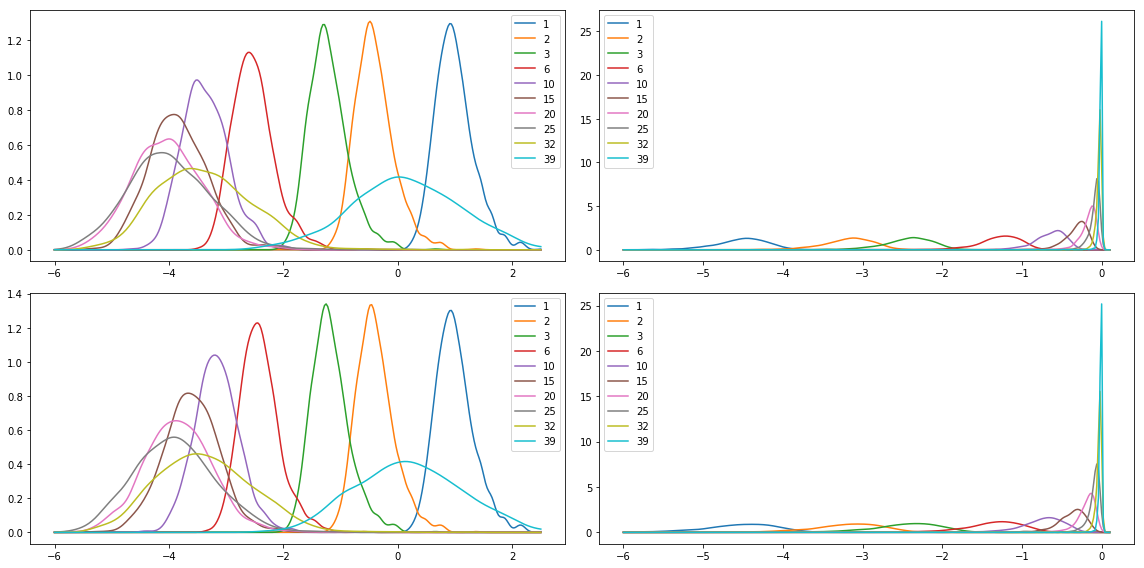

In [501]:
# Model 1 data
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,8))

ax = axes[0][0]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[0]
    data = paired_data({k:v[0]*1e9 for k,v in model.items()})
    data = np.log([row.one for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  2.5, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()
ax = axes[1][0]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[0]
    data = paired_data({k:v[0]*1e9 for k,v in model.items()})
    data = np.log([row.two for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  2.5, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()

ax = axes[0][1]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[0]
    data = paired_data({k:v[1] for k,v in model.items()})
    data = np.log([row.one for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  0.1, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()
ax = axes[1][1]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[0]
    data = paired_data({k:v[1] for k,v in model.items()})
    data = np.log([row.two for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  0.1, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()
fig.tight_layout()

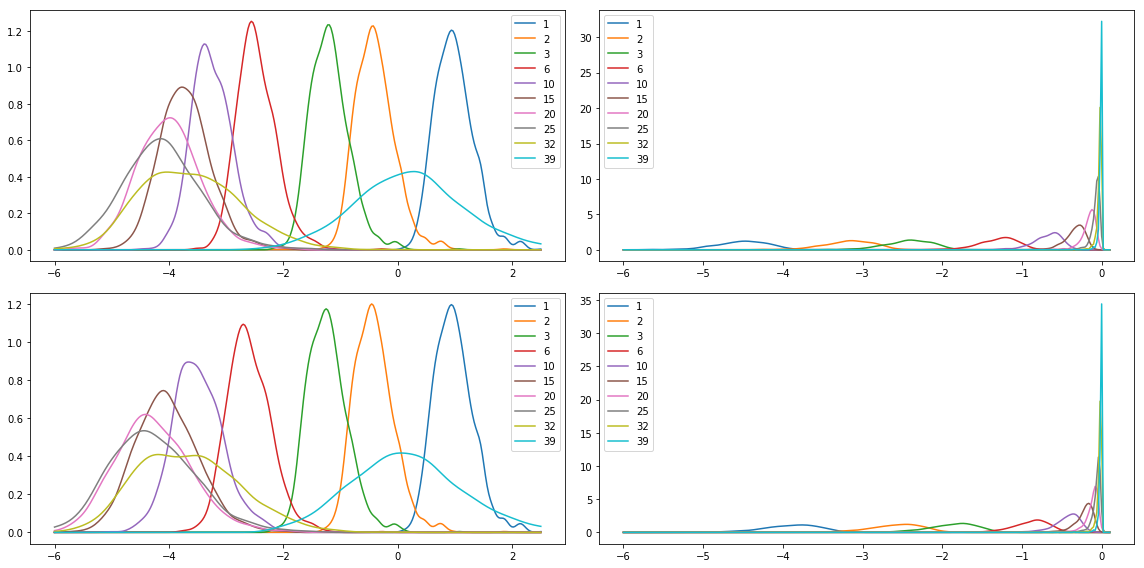

In [502]:
# Model 2 data
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,8))

ax = axes[0][0]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[1]
    data = paired_data({k:v[0]*1e9 for k,v in model.items()})
    data = np.log([row.one for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  2.5, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()
ax = axes[1][0]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[1]
    data = paired_data({k:v[0]*1e9 for k,v in model.items()})
    data = np.log([row.two for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  2.5, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()

ax = axes[0][1]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[1]
    data = paired_data({k:v[1] for k,v in model.items()})
    data = np.log([row.one for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  0.1, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()
ax = axes[1][1]
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[1]
    data = paired_data({k:v[1] for k,v in model.items()})
    data = np.log([row.two for row in data])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-6,  0.1, 300)
    ax.plot(x, ker(x), label=size)
ax.legend()
fig.tight_layout()

Thought about other visualisation.  This is sort of combining the scatter plots all onto one graph.

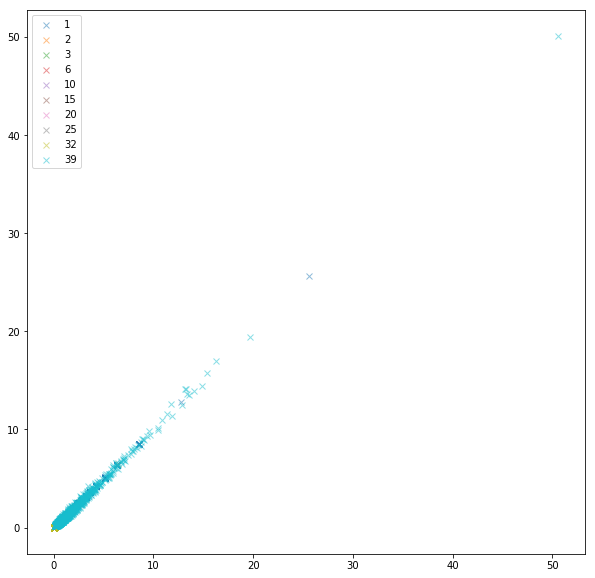

In [503]:
fig, ax = plt.subplots(figsize=(10,10))

data = collections.defaultdict(list)
for size in brier_ms:
    model = list(data_by_source_model(brier_ms[size]))[1]
    model = {k:v[0]*1e9 for k,v in model.items()}
    #model = {k:v[1] for k,v in model.items()}
    for row in paired_data(model):
        data[row.key].append((row.one, row.two))

data_by_levels = {k:[] for k in brier_ms}
for _, pts in data.items():
    for k, pt in zip(brier_ms, np.asarray(pts)):
        data_by_levels[k].append(pt)
        
import itertools
for (s, pts), m in zip(data_by_levels.items(), itertools.cycle(["x", "+", ".", "d"])):
    pts = np.asarray(pts)
    ax.scatter(*pts.T, marker="x", linewidth=1, alpha=0.5, label=str(s))
    #ax.scatter(*pts.T, marker=m, color="black", linewidth=1, alpha=0.5, label=str(s))
ax.legend()
None

Each size aggregation seems to cluster.  Here we experimented with "normalising" in some way, and plotting the resulting "curve".  The result is a mess...

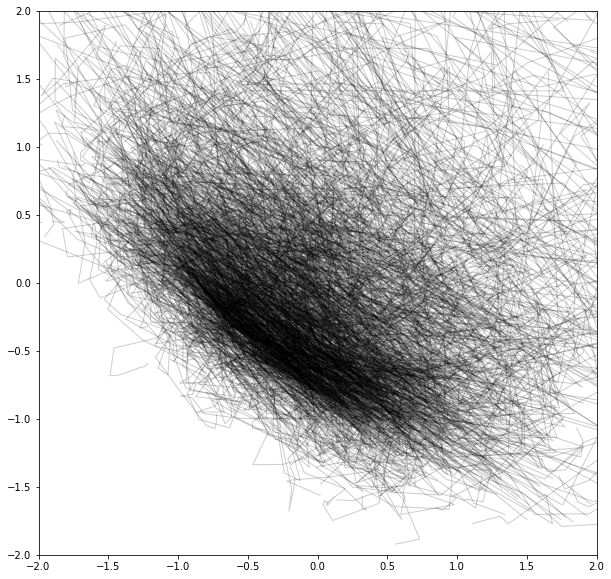

In [504]:
import scipy.linalg
centres = [np.mean(pts, axis=0) for pts in data_by_levels.values()]
def cov(pts):
    m = np.cov(pts, rowvar=False)
    return scipy.linalg.fractional_matrix_power(m, -0.5)
covs = [cov(pts) for pts in data_by_levels.values()]

fig, ax = plt.subplots(figsize=(10,10))
for pts in data.values():
    pts = [np.dot(mat, pt - centre) for pt, centre, mat in zip(pts, centres, covs)]
    pts = np.asarray(pts).T
    ax.plot(*pts, color="black", linewidth=1, alpha=0.2)
ax.set(xlim=[-2,2], ylim=[-2,2])
None

Similar idea, but as a scatter plot.  Still a mess...

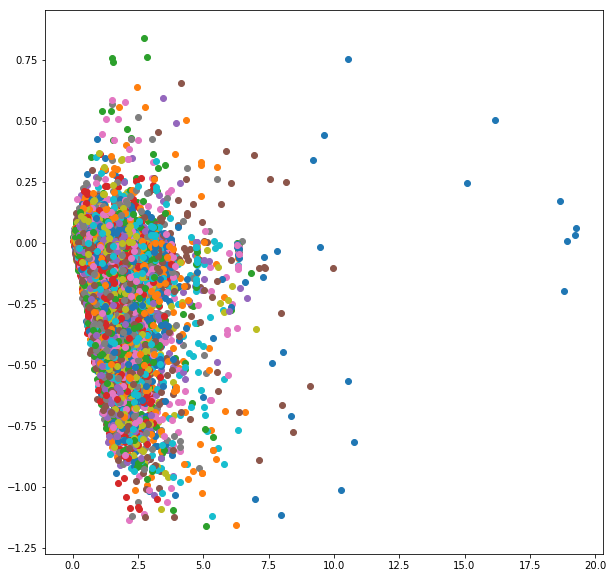

In [505]:
stds = [np.std(pts, axis=0)[0] for pts in data_by_levels.values()]

fig, ax = plt.subplots(figsize=(10,10))
for pts in data.values():
    pts = [np.asarray(pt) / s for pt, s in zip(pts, stds)]
    pts = np.asarray([ [x, y-x] for x,y in pts])
    pts = np.asarray(pts).T
    #ax.plot(*pts, color="black", linewidth=1, alpha=0.2)
    ax.scatter(*pts)
#ax.set(xlim=[-2,2], ylim=[-2,2])
None

# Bayesian

In [13]:
bayesian = process(all_data, lambda p, t : open_cp.evaluation.bayesian_dirichlet_prior(p, t, bias=4))

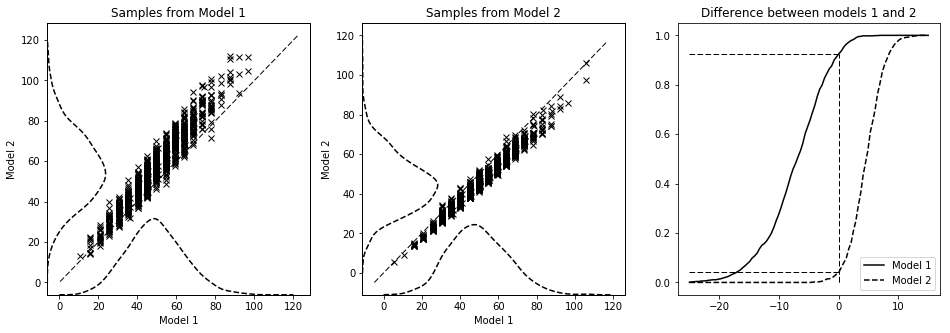

In [15]:
fig = three_up_plot(bayesian, -25, 15)
for one_model, ax in zip(data_by_source_model(bayesian), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (0, 120), 0.1, color="black", linestyle="--")

In [16]:
#fig.savefig("bayesian.pdf")

In [17]:
bayesian_pred = process(all_data, lambda p, t : open_cp.evaluation.bayesian_predictive(p, t, bias=4))

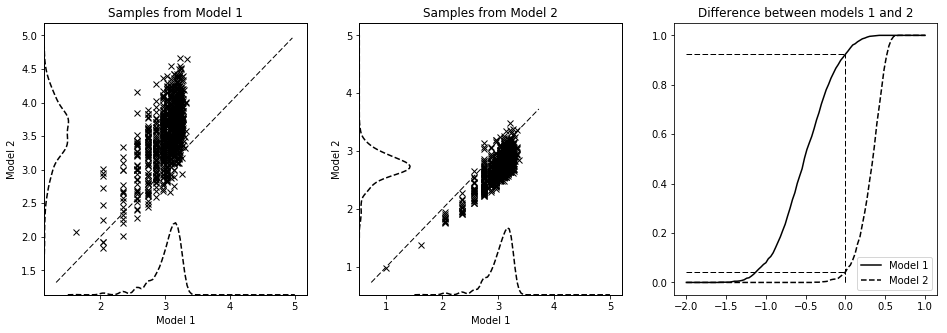

In [18]:
fig = three_up_plot(bayesian_pred, -2, 1)
for one_model, ax in zip(data_by_source_model(bayesian_pred), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (1.5, 5), 10, color="black", linestyle="--")

In [19]:
#fig.savefig("bayesian_pred.pdf")

Same again with `bias=10`.

In [25]:
bayesian = process(all_data, lambda p, t : open_cp.evaluation.bayesian_dirichlet_prior(p, t, bias=10))

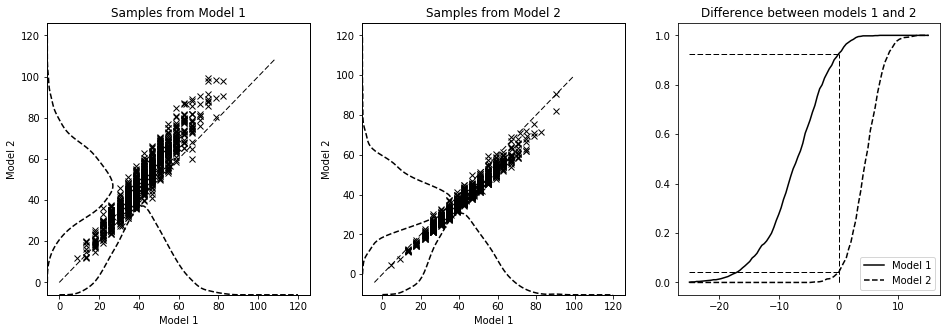

In [26]:
fig = three_up_plot(bayesian, -25, 15)
for one_model, ax in zip(data_by_source_model(bayesian), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (0, 120), 0.1, color="black", linestyle="--")

In [27]:
fig.savefig("bayesian.pdf")

In [28]:
bayesian_pred = process(all_data, lambda p, t : open_cp.evaluation.bayesian_predictive(p, t, bias=10))

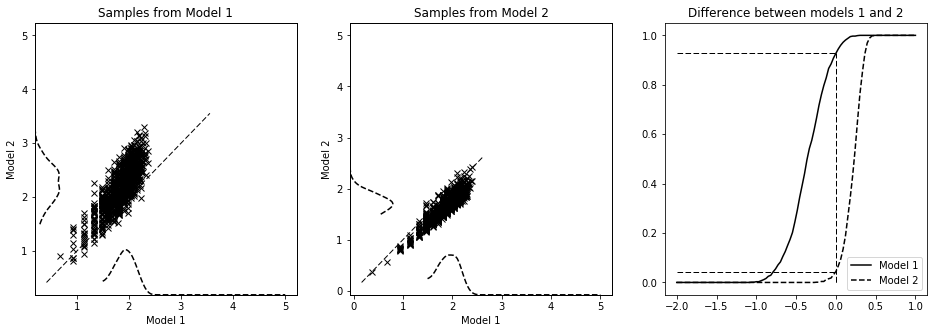

In [29]:
fig = three_up_plot(bayesian_pred, -2, 1)
for one_model, ax in zip(data_by_source_model(bayesian_pred), fig.axes):
    d = paired_data(one_model)
    ax1, ax2 = add_kernels(ax, d, (1.5, 5), 10, color="black", linestyle="--")

In [30]:
fig.savefig("bayesian_pred.pdf")